### Problem Statement

For starters let us write an agent to solve a simple optimization problem.
1. Data Generator: Write a piece of code which produces our ground truth data as
y=f(x) where f(x) = −0.2 + 0.4 ∗ x and x should be in the range [-1,1]. Produce a
plot of f(x).
2. Function: The function we’d like to fit is f(x; α, β) = α + β ∗ x Write a piece of
code which produces ŷ = f(x; α, β). Produce a plot for all parameters equal to one.
3. Discretized Space: Let also be α and β be in the range [-1,1]. Their values should
be discretized with stepsize 0.2. Plot this space as squares in a plane where each
discrete pair is denoted by a dot in the middle of one of the squares (should be 64
squares in the end).
4. Rewards: Use the RMSE value at a given point to come up with rewards for this
space, i.e lower RMSE should give more reward then higher RMSE. Add the
Rewards to your plot from 3.
5. Q Learning: Write an agent which is able to walk this discrete space to find the
parameters of the true data generator.

In [55]:

# import random
# import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib nbagg  

# core imports
import os
import sys
import random
import numpy as np

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
# local imports
from autonetwork.environments.single_parameter import TwoParaEnv
from autonetwork.agents.qlearning_agent import QLearningAgent
from autonetwork.simulation import Run, Exploration



interactive = True



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
def data_generator(input_data):
    """
    Generate ground truth data (y) based on
    y=f(x) where f(x) = −0.2 + 0.4 ∗ x
    """
    return -0.2 + 0.4 * input_data

def fit_function(x, alpha, beta):
    """
    Return predicted value (y_bar)
    """
    return alpha + beta * x

def discrete_parameter_space(input_range, step_size=0.2):
    """
    We have alpha and beta parameters for the model.
    We are creating discrete parameter space for the modeling purpose.
    """
    return np.arange(input_range[0]+step_size, input_range[1], step_size)

def rmse_func(targets, predictions):
    """
    it calculate the root mean square value
    """
    return np.sqrt(np.mean((predictions-targets)**2))

def continuous_reward_func(current_input):
    """
    continuous rewards based on rmse value)
    """
    
    # making sure higher rmse gets lower reward
    if np.isclose(0, current_input):
        return 10
    return 1/current_input
    

### 1. Generate Ground Truth

In [34]:
input_range = (-1, 1)
data_length = 20
input_data = np.linspace(input_range[0], input_range[1], data_length)
ground_truth = data_generator(input_data)

In [35]:
ground_truth

array([-0.6       , -0.55789474, -0.51578947, -0.47368421, -0.43157895,
       -0.38947368, -0.34736842, -0.30526316, -0.26315789, -0.22105263,
       -0.17894737, -0.13684211, -0.09473684, -0.05263158, -0.01052632,
        0.03157895,  0.07368421,  0.11578947,  0.15789474,  0.2       ])

### 2. Plot Grouth Truth

<IPython.core.display.Javascript object>


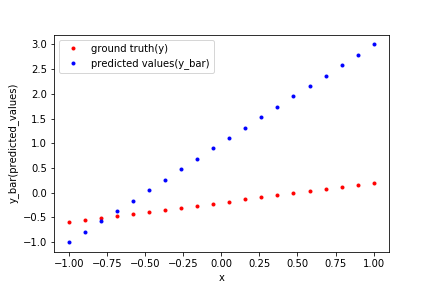

In [36]:
index = np.linspace(input_range[0], input_range[1], data_length)
plt.plot(index, ground_truth, 'r.', label='ground truth(y)') # x
plt.legend(loc="upper left")
plt.xlabel('x', fontsize=16)
plt.ylabel('y(ground truth)', fontsize=16)
plt.show()

### 3. Fit model (f(x; α, β) = α + β ∗ x) with α, β = 1

In [37]:
alpha = 1
beta = 2
fitted_values = fit_function(input_data, alpha, beta)

In [38]:
plt.plot(index, fitted_values, 'b.', label='predicted values(y_bar)') # x

plt.legend(loc="upper left")
plt.xlabel('x', fontsize=10)
plt.ylabel('y_bar(predicted_values)', fontsize=10)
plt.show()

### 4. Discretize the parameter space and create square maze

In [39]:
discrete_alphas = discrete_parameter_space(input_range)
discrete_betas = discrete_parameter_space(input_range)

In [40]:
discrete_alphas, discrete_betas

(array([-8.00000000e-01, -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,
        -2.22044605e-16,  2.00000000e-01,  4.00000000e-01,  6.00000000e-01,
         8.00000000e-01]),
 array([-8.00000000e-01, -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,
        -2.22044605e-16,  2.00000000e-01,  4.00000000e-01,  6.00000000e-01,
         8.00000000e-01]))

<IPython.core.display.Javascript object>


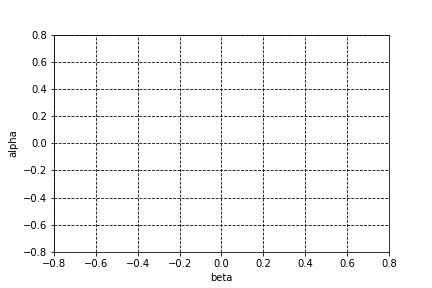

In [41]:
fig, ax = plt.subplots()
ax.set_xlim((-0.8,0.8))
ax.set_ylim((-0.8,0.8))
x0,x1 = ax.get_xlim()
y0,y1 = ax.get_ylim()
ax.grid(b=True, which='major', color='k', linestyle='--')
# fig.savefig('test.png', dpi=600)
# plt.close(fig)
plt.xlabel('beta', fontsize=10)
plt.ylabel('alpha', fontsize=10)
plt.show()

### 5. Plot the rewards on the space based on RMSE value

In [50]:
# apply alpha, beta pair from discrete_alphas, discrete_betas to calculate the rewards
reward_matrix = []
positive_reward_20_spaces = []
positive_reward_10_spaces = []
positive_reward_5_spaces = []
negative_reward_spaces = []
for alpha in discrete_alphas:
    reward_row = []
    for beta in discrete_betas:
        predictions = fit_function(input_data, alpha, beta)
        rmse = rmse_func(ground_truth, predictions)
        reward = continuous_reward_func(rmse)
        if reward == 20:
            positive_reward_20_spaces.append([beta + 0.1, alpha+0.1])
        elif reward == 10:
            positive_reward_10_spaces.append([beta + 0.1, alpha+0.1])
        elif reward == 5:
            positive_reward_5_spaces.append([beta + 0.1, alpha+0.1])
        else:
            negative_reward_spaces.append([beta + 0.1, alpha+0.1])
        reward_row.append(reward)
    
    reward_matrix.append(reward_row)


### 6. Q-learning 

In [51]:
R = np.array(reward_matrix)
R

array([[ 1.0596846 ,  1.17167929,  1.29554824,  1.42475069,  1.54497077,
         1.63356644,  1.66666667,  1.63356644,  1.54497077],
       [ 1.20339966,  1.37565631,  1.58952689,  1.84858491,  2.13712604,
         2.39225658,  2.5       ,  2.39225658,  2.13712604],
       [ 1.32392127,  1.56475353,  1.90419384,  2.40679931,  3.17905379,
         4.27425207,  5.        ,  4.27425207,  3.17905379],
       [ 1.37292412,  1.64750894,  2.05938618,  2.74584824,  4.11877236,
         8.23754471, 10.        ,  8.23754471,  4.11877236],
       [ 1.32392127,  1.56475353,  1.90419384,  2.40679931,  3.17905379,
         4.27425207,  5.        ,  4.27425207,  3.17905379],
       [ 1.20339966,  1.37565631,  1.58952689,  1.84858491,  2.13712604,
         2.39225658,  2.5       ,  2.39225658,  2.13712604],
       [ 1.0596846 ,  1.17167929,  1.29554824,  1.42475069,  1.54497077,
         1.63356644,  1.66666667,  1.63356644,  1.54497077],
       [ 0.92429246,  0.99581588,  1.06856302,  1.13766336,  1

<IPython.core.display.Javascript object>


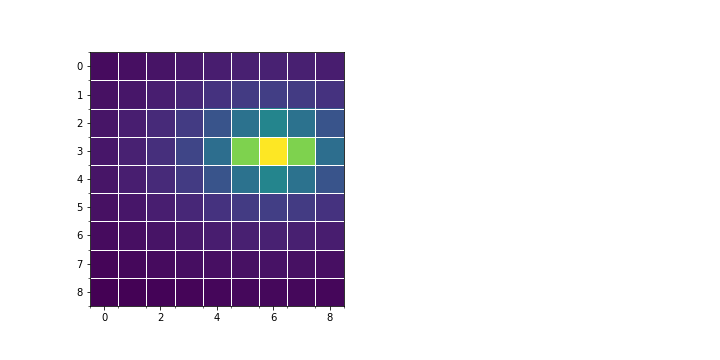

In [52]:
from matplotlib import pyplot as plt
from matplotlib import pylab
import matplotlib.gridspec as gridspec

# rewards table
R = np.array(reward_matrix)
fig3 = pylab.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 2)
ax = pylab.subplot(gs[:, 0])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.imshow(R, interpolation='none', cmap='viridis')

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.set_xticks(np.arange(-.5, 9, 1), minor=True);
ax.set_yticks(np.arange(-.5, 9, 1), minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
fig3.canvas.draw()

<IPython.core.display.Javascript object>


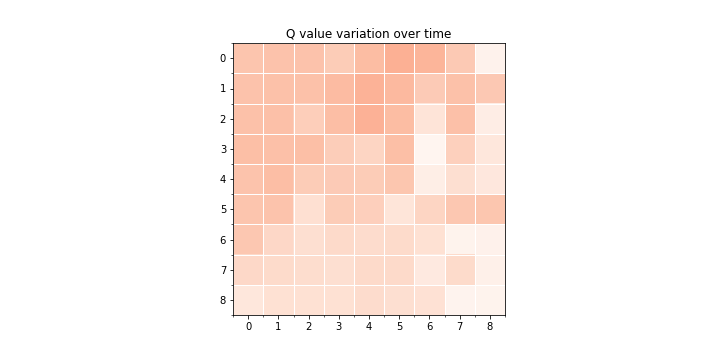

<IPython.core.display.Javascript object>


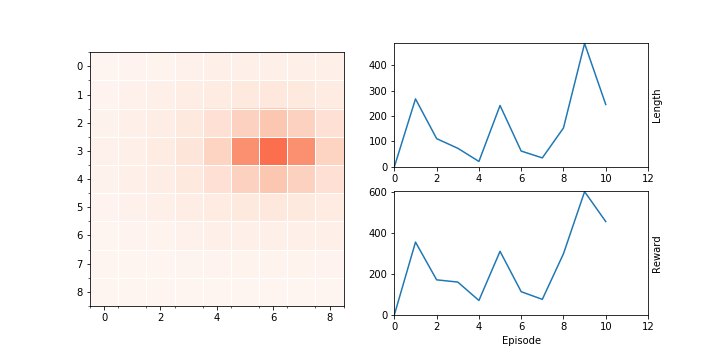

In [56]:
# rewards table
R = np.array(reward_matrix)

# can we avoid going to same state? by tracking it ?

# Exploration parameters
epsilon = 0.95                # Exploration rate
max_epsilon = 0.95             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001             # Exponential decay rate for exploration prob

exploration = Exploration(epsilon, max_epsilon, min_epsilon, decay_rate)

interactive = True
max_number_of_episodes = 10
env = TwoParaEnv(R)
agent = QLearningAgent(range(env.action_space.n))
run = Run(env, agent)
run.run_qlearning(exploration, max_number_of_episodes, interactive)
# color gradients for the visual appealing to look the movements.
# boundary : choose another action instead of remain at the same state (sample from the actions again)
# looking at the gradients
# normalize loss/ q values
# 